{'env': {'start': -2, 'step_size': 0.5, 'shape': {'x': 8, 'y': 8}, 'n_players': 3, 'Cx_lengthscale': 2, 'Cx_noise': 0.01, 'Fx_lengthscale': 0.7, 'Fx_noise': 0.01, 'Cx_beta': 1.5, 'Fx_beta': 1.5, 'generate': True, 'env_file_name': 'env_data.pkl', 'cov_module': 'Sq_exp'}, 'experiment': {'name': 'exploit', 'generate_regret_plot': True, 'folder': 'GP'}, 'agent': {'Lc': 1.5, 'explore_exploit_strategy': 1, 'Cx_lengthscale': 2, 'Cx_noise': 0.007, 'Fx_lengthscale': 0.8, 'Fx_noise': 0.01, 'Cx_beta': 1.5, 'Fx_beta': 2.0, 'mean_shift_val': 2, 'use_goose': False, 'obs_model': 'disc_center', 'cov_module': 'Sq_exp', 'recommend': 'UCB', 'Two_stage': False, 'sol_domain': 'opti'}, 'common': {'dim': 2, 'constraint': 0.3, 'epsilon': 0.25, 'disk_size': 1}, 'algo': {'n_CI_samples': 1, 'n_iter': 200, 'eps_density_thresh': 0.5, 'goose_steps': 150, 'use_doubling_trick': False}}


/home/mht/anaconda3/envs/gpyt/lib/python3.8/site-packages/botorch/models/gpytorch.py:119: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(
/home/mht/anaconda3/envs/gpyt/lib/python3.8/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/mht/anaconda3/envs/gpyt/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/mht/anaconda3/envs/gpyt/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitt

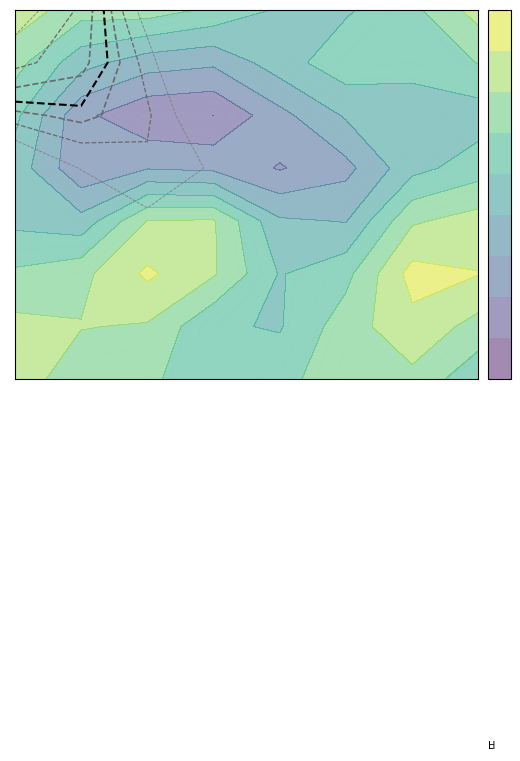

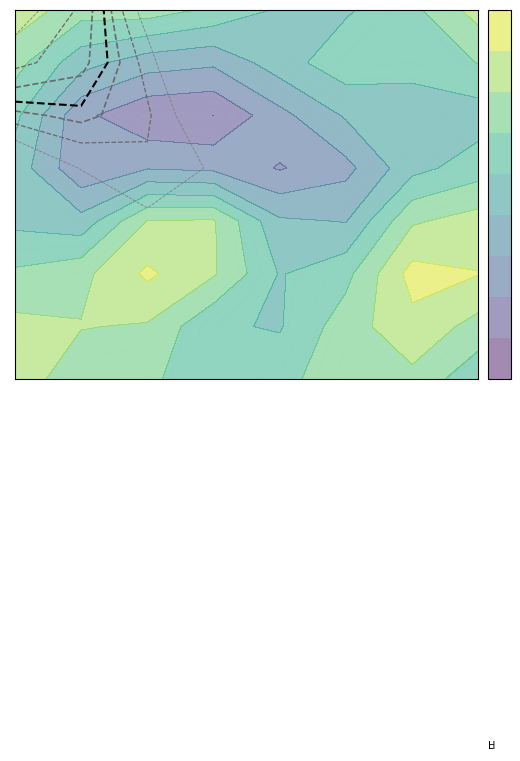

In [2]:
# The environment for this file is a ~/work/rl
import argparse
import errno
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import torch
import yaml
import numpy as np
import pandas as pd

workspace = '/home/mht/PycharmProjects/mac_decision/src/SafeMaC'
import sys
sys.path.append(workspace)

from utils.environement import GridWorld
from utils.ground_truth import GroundTruth
from utils.helper import submodular_optimization, idxfromloc
from utils.initializer import get_players_initialized
import types
import networkx as nx
# warnings.filterwarnings("ignore")

args = {'param': 'GP_base_base',
        'env_idx': 100,
        'generate': False,
        'noise_sigma': 0.01,
        'iter': 1000}
args = types.SimpleNamespace(**args)
env, agent, algo = args.param.split('_')
params = {}
env = 'env_' + env
agent = 'agent_' + agent
algo = 'algo_' + algo
# 1) Load the config file
for param in [env, agent, algo]:
    with open(workspace + "/params/" + param + ".yaml") as file:
        params.update(yaml.load(file, Loader=yaml.FullLoader))
print(params)

if not args.generate:
    params["env"].update({"generate": True})

params["env"].update({"Fx_noise" : args.noise_sigma})
params["agent"].update({"Fx_noise": args.noise_sigma})

env_load_path = (
    workspace
    + "/experiments/"
    + params["experiment"]["folder"] + '_' + str(args.noise_sigma)
    + "/"
    + env + '_'
    + str(args.env_idx)
    + "/"
)
save_path = env_load_path + "/" + args.param + "/"

if not os.path.exists(save_path):
    try:
        os.makedirs(save_path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

# 3) Setup the environement
env = GridWorld(
    env_params=params["env"], common_params=params["common"], env_dir=env_load_path
)
env.plot()

In [30]:
from matplotlib import patches
def add_walls(x, y, dx, dy, ax):
    rect1 = patches.Rectangle([x-0.5, y-0.5], dx+1, dy+1, edgecolor='gray', facecolor='gray', alpha=0.3)
    ax.add_patch(rect1)
    
    rect = patches.Rectangle([x, y], dx, dy, edgecolor='red', facecolor='red', alpha=0.5)
    ax.add_patch(rect)   

def add_legend(ax):
    # Create proxy artists for legend
    proxy1 = plt.Line2D([0], [0], linestyle='none', marker='s', markersize=10, markerfacecolor='red', markeredgecolor='red', label='Obstacles')
    proxy2 = plt.Line2D([0], [0], linestyle='none', marker='s', markersize=10, markerfacecolor='gray', markeredgecolor='gray', label='Prior knowledge')

    # Add legend
    ax.legend(handles=[proxy1, proxy2], loc='best')

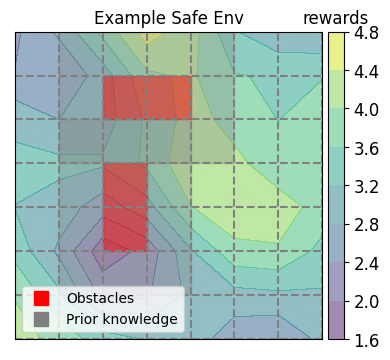

In [46]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def fmt(x):
        s = f"{x:.1f}"
        if s.endswith("0"):
            s = f"{x:.0f}"
        return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} %"

x = env.grid_V.transpose(0, 1).reshape(-1, env.Nx, env.Ny)[0]
y = env.grid_V.transpose(0, 1).reshape(-1, env.Nx, env.Ny)[1]
z = env.get_true_safety_func().reshape(env.Nx, env.Ny)
z2 = env.get_true_objective_func().reshape(env.Nx, env.Ny)
f, ax = plt.subplots(figsize=(4, 4))

levels = 20
CS1 = ax.contour(
    x.numpy(), y.numpy(), z2.numpy(), levels=levels, linewidths=0.01
)
plt.contourf(x.numpy(), y.numpy(), z2.numpy(),
                cmap=plt.cm.viridis, alpha=0.5)
# ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="2%")
cbar = plt.colorbar(cax=cax, aspect=60)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('rewards')

ax.yaxis.set_ticklabels([])
ax.yaxis.set_ticks([])
ax.xaxis.set_ticklabels([])
ax.xaxis.set_ticks([])
ax.hlines(np.linspace(-2, 1.5, 8), -2, 1.5, colors='gray', linestyles='--')
ax.vlines(np.linspace(-2, 1.5, 8), -2, 1.5, colors='gray', linestyles='--')
ax.axis("equal")
# plt.axis('off')


add_walls(-1.0, -1.0, 0.5, 1.0, ax)
add_walls(-1.0, 0.5, 1.0, 0.5, ax)
add_legend(ax)

ax.set_title('Example Safe Env')

plt.tick_params(
    axis="x",  # changes apply to the x-axis
    which="both",  # both major and minor ticks are affected
    bottom=False,  # ticks along the bottom edge are off
    top=False,  # ticks along the top edge are off
    labelbottom=False,
)  # labels along the bottom edge are off
plt.tick_params(
    axis="x",  # changes apply to the x-axis
    which="both",  # both major and minor ticks are affected
    bottom=False,  # ticks along the bottom edge are off
    top=False,  # ticks along the top edge are off
    labelbottom=False,
)  # labels along the bottom edge are off
# plt.show()
plt.tight_layout()
plt.savefig(env.env_dir + 'env_paper.pdf')

In [3]:
plt.figure(figsize=(19.2, 12))
x = env.grid_V.transpose(0, 1).reshape(-1, env.Nx, env.Ny)[0]
y = env.grid_V.transpose(0, 1).reshape(-1, env.Nx, env.Ny)[1]
z = env.get_true_objective_func().reshape(env.Nx, env.Ny)